## CAPSTONE: BATTLE OF THE NEIGHBOURHOODS

#### In this report, we attempt to identify new food business opportunities which can be implemented within the Singapore Market. This can be done by analysing some of the trends such as population growth, ethnicity, frequent mode of transport.

### 1. Import Python  Libraries 

In [579]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

# Numpy and Pandas libraries were already imported at the beginning of this notebook.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

import requests # library to handle requests
import lxml.html as lh
import bs4 as bs
import urllib.request

print('Libraries imported.')

Libraries imported.


### 2. Downloading Singapore towns list with population size 

In [580]:
import zipfile
import os
# for ibm-linux: !wget -q -O 'estimated-resident-population-living-in-hdb-flats.zip' "https://data.gov.sg/dataset/10ded2fc-f473-4af0-9ab7-18bd13c7066e/download"
zf = zipfile.ZipFile('./estimated-resident-population-living-in-hdb-flats.zip')
sgp_population_by_town_data = pd.read_csv(zf.open("estimated-resident-population-in-hdb-flats-by-town.csv"))
sgp_population_by_town_data.rename(columns = {'town_or_estate':'Town'}, inplace = True)
sgp_population_by_town_data

#IMPORT Public transport Utilisation 
zf= zipfile.ZipFile('./public-transport-utilisation-average-public-transport-ridership.zip')
sgp_transport = pd.read_csv(zf.open('public-transport-utilisation-average-public-transport-ridership.csv'))

#IMPORT Singapore residents by AGE, ETHNIC, GENDER
zf= zipfile.ZipFile('./resident-population-by-ethnicity-gender-and-age-group.zip')
sgp_population_rate_by_age = pd.read_csv(zf.open('singapore-residents-by-age-group-ethnic-group-and-sex-end-june-annual.csv'))
                            
sgp_population_rate_by_ethnic = pd.read_csv(zf.open('singapore-residents-by-ethnic-group-and-sex-end-june-annual.csv'))                    

####  2.1 Singapore Total Population vs Singapore HDB Population 

Title: 'Singapore Residents By Age Group, Ethnic Group And Gender, End June, Annual' 

Title: 'Estimated Singapore Resident Population in HDB Flats'


Source: Data.gov.sg 




In this data, we will only be interested in extracting the total Singapore resident population data between the period of 2008 to 2017 so that we can perform analysis between other datasets of the same period. 

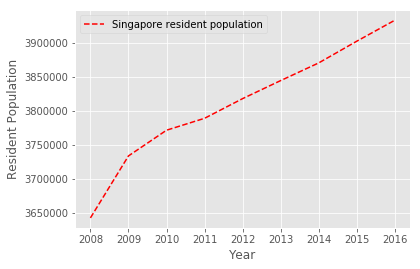

In [581]:
#sgp_population_by_town_data[sgp_population_by_town_data['financial_year']==2008]
sgp_total_pop_time = sgp_population_rate_by_ethnic[sgp_population_rate_by_ethnic['level_1']== 'Total Residents']
sgp_total_pop_time= sgp_total_pop_time.drop('level_1',axis=1).reset_index().drop('index',axis=1)
#Filter out results between 2008:2016
sgp_total_pop_time= sgp_total_pop_time[48:57]

x1=sgp_total_pop_time['year']
y1=sgp_total_pop_time['value']
plt.xlabel('Year')
plt.ylabel('Resident Population')
plt.plot(x1,y1,'r--',label='Singapore resident population')
plt.legend(loc= 'upper left')
plt.show()


In [582]:
sgp_2008 = sgp_total_pop_time['value'].iloc[0]
sgp_2016= sgp_total_pop_time['value'].iloc[8]
pop_pct_change = (((sgp_2016-sgp_2008)/sgp_2008)*100).round(2)
print('The total resident population in Singapore has increased by {} % between the period of 2008 and 2016'.format(pop_pct_change))
print('Total change: {}'.format(sgp_2016-sgp_2008))

The total resident population in Singapore has increased by 7.99 % between the period of 2008 and 2016
Total change: 290900


#### 2.2 Singapore total population breakdown by ethnic groups 
These includes: Malays, Chinese, Indians and other races. It will be important to analyse the growth of these ethnic groups such that we can identify growth opportunities for these respective segments.

In [583]:
# Breakdown sgp_population_rate_by_ethnic to range of 2008:2016
sgp_population_rate_by_ethnic= sgp_population_rate_by_ethnic[720:854].reset_index()

In [584]:
sgp_population_rate_by_ethnic= sgp_population_rate_by_ethnic.drop(['index'],axis=1)

In [585]:
#Assign sgp_population_rate to the various ethnic groups
sgp_population_rate_malay = sgp_population_rate_by_ethnic[sgp_population_rate_by_ethnic['level_1']=='Total Malays']
sgp_population_rate_chinese = sgp_population_rate_by_ethnic[sgp_population_rate_by_ethnic['level_1']=='Total Chinese']
sgp_population_rate_indians = sgp_population_rate_by_ethnic[sgp_population_rate_by_ethnic['level_1']=='Total Indians']
sgp_population_rate_others = sgp_population_rate_by_ethnic[sgp_population_rate_by_ethnic['level_1']=='Other Ethnic Groups (Total)']

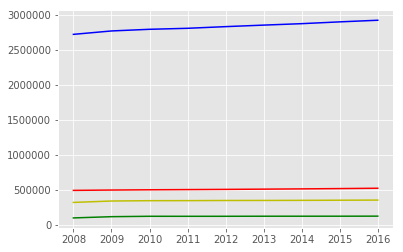

In [586]:
x_m =sgp_population_rate_malay['year']
y_m = sgp_population_rate_malay['value']
x_c = sgp_population_rate_chinese['year']
y_c= sgp_population_rate_chinese['value']
x_i = sgp_population_rate_indians['year']
y_i= sgp_population_rate_indians['value']
x_o=sgp_population_rate_others['year']
y_o=sgp_population_rate_others['value']
plt.plot(x_m,y_m,'r')
plt.plot(x_c,y_c,'b')
plt.plot(x_i,y_i,'y')
plt.plot(x_o,y_o,'g')
plt.show()

In [587]:
sgp_chn_2016= sgp_population_rate_chinese[sgp_population_rate_chinese['year']==2016].value
sgp_mly_2016 = sgp_population_rate_malay[sgp_population_rate_malay['year']==2016].value
sgp_ind_2016 = sgp_population_rate_indians[sgp_population_rate_indians['year']==2016].value
sgp_oth_2016 = sgp_population_rate_others[sgp_population_rate_others['year']==2016].value

sgp_chn_2008 = sgp_population_rate_chinese[sgp_population_rate_chinese['year']==2008].value
sgp_mly_2008 = sgp_population_rate_malay[sgp_population_rate_malay['year']==2008].value
sgp_ind_2008 = sgp_population_rate_indians[sgp_population_rate_indians['year']==2008].value
sgp_oth_2008 = sgp_population_rate_others[sgp_population_rate_others['year']==2008].value

In [588]:
pct_chg_chn = (((sgp_chn_2016.iloc[0]-sgp_chn_2008.iloc[0])/sgp_chn_2008.iloc[0])*100).round(2)
pct_chg_mly = (((sgp_mly_2016.iloc[0]-sgp_mly_2008.iloc[0])/sgp_mly_2008.iloc[0])*100).round(2)
pct_chg_ind = (((sgp_ind_2016.iloc[0]-sgp_ind_2008.iloc[0])/sgp_ind_2008.iloc[0])*100).round(2)
pct_chg_oth = (((sgp_oth_2016.iloc[0]-sgp_oth_2008.iloc[0])/sgp_oth_2008.iloc[0])*100).round(2)

d={'Ethnic groups':['Chinese','Malay','Indians','Others'],
  '2008':[sgp_chn_2008.iloc[0],sgp_mly_2008.iloc[0],sgp_ind_2008.iloc[0],sgp_oth_2008.iloc[0]],
  '2016':[sgp_chn_2016.iloc[0],sgp_mly_2016.iloc[0],sgp_ind_2016.iloc[0],sgp_oth_2016.iloc[0]],
  'pct_change':[pct_chg_chn,pct_chg_mly,pct_chg_ind,pct_chg_oth]}

pct_growthdf = pd.DataFrame(data=d)

print('\n')

print("The Chinese population in Singapore has grown by {} % between the period of 2008-2017, from a value of {} to {} . ".format(pct_chg_chn,sgp_chn_2008.iloc[0],sgp_chn_2016.iloc[0]))
print("The Malay population in Singapore has grown by {} % between the period of 2008-2017, from a value of {} to {} . ".format(pct_chg_mly,sgp_mly_2008.iloc[0],sgp_mly_2016.iloc[0]))
print("The Indian population in Singapore has grown by {} % between the period of 2008-2017, from a value of {} to {} . ".format(pct_chg_ind,sgp_ind_2008.iloc[0],sgp_ind_2016.iloc[0]))
print("Minority Ethnic Population in Singapore has grown by {} % between the period of 2008-2017, from a value of {} to {} . ".format(pct_chg_oth,sgp_oth_2008.iloc[0],sgp_oth_2016.iloc[0]))



The Chinese population in Singapore has grown by 7.4 % between the period of 2008-2017, from a value of 2721779 to 2923172 . 
The Malay population in Singapore has grown by 6.22 % between the period of 2008-2017, from a value of 495110 to 525888 . 
The Indian population in Singapore has grown by 10.34 % between the period of 2008-2017, from a value of 323431 to 356876 . 
Minority Ethnic Population in Singapore has grown by 24.71 % between the period of 2008-2017, from a value of 102339 to 127623 . 


In [589]:
pct_growthdf.set_index('Ethnic groups')

,2008,2016,pct_change
Ethnic groups,,,
Chinese,2721779,2923172,7.40
Malay,495110,525888,6.22
Indians,323431,356876,10.34
Others,102339,127623,24.71


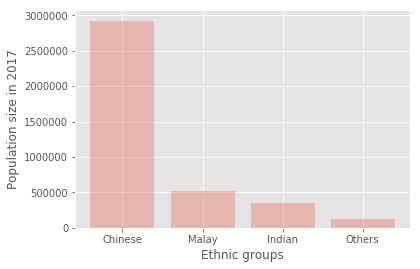

<Figure size 864x576 with 0 Axes>

In [613]:
ethnics =('Chinese','Malay','Indian','Others')
y_pos = np.arange(len(ethnics))
pop_size_in_2016 = [sgp_chn_2016.iloc[0],sgp_mly_2016.iloc[0],sgp_ind_2016.iloc[0],sgp_oth_2016.iloc[0]]
plt.bar(y_pos,pop_size_in_2016,align='center',alpha=0.3)
plt.xticks(y_pos,ethnics)
plt.ylabel('Population size in 2017')
plt.xlabel('Ethnic groups')
plt.figure(figsize=(12,8))
plt.show()

Clearly, this diagram shows that Singapore is largely chinese dominated. 
Further analysis of the populace shows that between the period of 2008 - 2017, Minority Ethnic Population has seen a 25.09% increase in population size. This could be attributed to increase in new residents during the period. However, the Chinese populace remains the majority at large with a total size of 2.95 million in the year of 2017.

#### 2.3 Singapore residents living in HDB

In [591]:
population_rate_chart = sgp_population_by_town_data[sgp_population_by_town_data['Town']=='Total']

In [592]:
population_rate_chart

,financial_year,Town,population
26,2008,Total,3020100
53,2009,Total,3094100
80,2010,Total,3125900
107,2011,Total,3156900
134,2012,Total,3165900
161,2013,Total,3213000
188,2014,Total,3217400
215,2015,Total,3234800
242,2016,Total,3249900


### 4. SIngapore hdb population growth in numbers

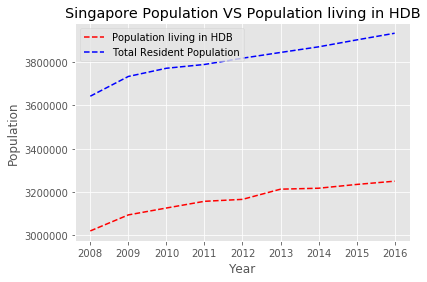

In [593]:
import matplotlib.pyplot as plt 
x= population_rate_chart['financial_year']
y= population_rate_chart['population']

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Singapore Population VS Population living in HDB')
plt.plot(x,y,'r--',label='Population living in HDB')
plt.plot(x1,y1,'b--',label='Total Resident Population')
plt.legend(loc='upper left')
# plt.ylim(300000, 420000)
plt.show()

In [594]:
np.corrcoef(y1,y)

# Correlation value = 0.9893 therefore this shows strong positive
# correlation between Singapore population and population living in HDB
# This is true given that 80% of the population live in HDB flats. 

array([[1.        , 0.98935578],
       [0.98935578, 1.        ]])

Next given that we established that majority of the populace lives in HDB flats, we want to establish the mode of transport 

In [595]:
sgp_population_by_town_data_2017 = sgp_population_by_town_data[sgp_population_by_town_data['financial_year'] == 2017] 

In [596]:
#type(sgp_population_by_town_data['population'][0]) returns numpy.int64 to ensure formatting

In [597]:
sgp_population_by_town_data_2017['population'].sum()

3247500

In [598]:
sgp_population_by_town_data_2017.dtypes

financial_year     int64
Town              object
population         int64
dtype: object

### 5. Retrieving only the population size by towns in year 2017

In [599]:
sgp_population_by_town_data_2017

,financial_year,Town,population
243,2017,Ang Mo Kio,143800
244,2017,Bedok,194700
245,2017,Bishan,63200
246,2017,Bukit Batok,114000
247,2017,Bukit Merah,145700
248,2017,Bukit Panjang,121100
249,2017,Bukit Timah,8400
250,2017,Central Area,27700
251,2017,Choa Chu Kang,169000
252,2017,Clementi,72300


In [600]:
towns=[]
pop=[]
for town,population in zip(sgp_population_by_town_data_2017['Town'],
                           sgp_population_by_town_data_2017['population']):
    towns.append(town)
    pop.append(population/100)                                                         
                                                            

Text(0, 0.5, 'Neighbourhood')

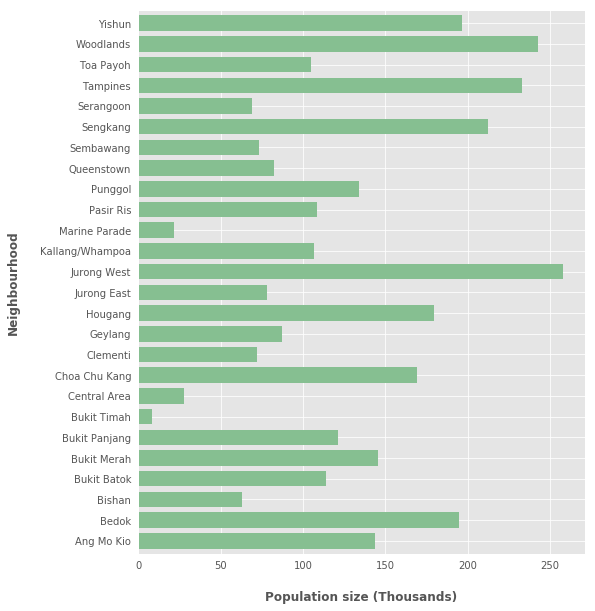

In [601]:
x= (sgp_population_by_town_data_2017.set_index('Town')['population']/1000)
x.plot(kind='barh')
ax= x.plot(kind='barh', figsize=(8,10), color = '#86bf91',zorder=2, width=0.75)
ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom= True, left = False, right = False, labelleft= True)

ax.set_xlabel('Population size (Thousands)', labelpad=20, weight='bold',size= 12)
ax.set_ylabel('Neighbourhood', labelpad=20, weight='bold',size=12)

In [602]:
# # Drop all financial year column
# sgp_population_by_town_data_2017 = sgp_population_by_town_data_2017.drop(['financial_year'],axis=1)
#Ensure that population is int64
sgp_population_by_town_data_2017['population']=sgp_population_by_town_data_2017['population'].astype(np.int64)
sgp_population_by_town_data_2017 = sgp_population_by_town_data_2017.reset_index()

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [603]:
sgp_population_by_town_data_2017 = sgp_population_by_town_data_2017.drop(['index'],axis=1)

### 6. Retrieving town coordinates

In [604]:
sgp_population_by_town_data_2017['Latitude']=0.0
sgp_population_by_town_data_2017['Longitude']=0.0

In [605]:
geo= Nominatim(user_agent='mypythonapi')
for idx,town in sgp_population_by_town_data_2017['Town'].iteritems():
    coord=geo.geocode(town+' '+'Singapore',timeout=10)
    if coord:
        sgp_population_by_town_data_2017.loc[idx,'Latitude']= coord.latitude
        sgp_population_by_town_data_2017.loc[idx,'Longitude']= coord.longitude
    else:
        sgp_population_by_town_data_2017.loc[idx,'Latitude']= NULL
        sgp_population_by_town_data_2017.loc[idx,'Longitude']=NULL
        

In [606]:
sgp_towns_with_coor = sgp_population_by_town_data_2017.drop(['financial_year'],axis=1)
sgp_towns_with_coor

,Town,population,Latitude,Longitude
0,Ang Mo Kio,143800,1.369842,103.846609
1,Bedok,194700,1.323976,103.930216
2,Bishan,63200,1.351452,103.848250
3,Bukit Batok,114000,1.349057,103.749591
4,Bukit Merah,145700,1.280628,103.830591
5,Bukit Panjang,121100,1.377921,103.771866
6,Bukit Timah,8400,1.354690,103.776372
7,Central Area,27700,1.290475,103.852036
8,Choa Chu Kang,169000,1.389260,103.743728
9,Clementi,72300,1.314026,103.762410


### 7. Generating Singapore Basemap

In [607]:
address='Singapore'
geolocator=Nominatim(user_agent='mypythonapi')
location=geolocator.geocode(address)
latitude= location.latitude
longitude= location.longitude
print("The geographical coordinate of {}, are {} and {}".format(address,location.latitude,location.longitude))

The geographical coordinate of Singapore, are 1.3408528 and 103.878446863736


In [608]:
#create a map of Singapore 
map_singapore= folium.Map(location=[latitude,longitude],tiles="OpenStreetMap",zoom_start=11)

#add towns to map
for lat,lng,town,pop in zip(sgp_towns_with_coor['Latitude'],sgp_towns_with_coor['Longitude'],
                        sgp_towns_with_coor['Town'],sgp_towns_with_coor['population']):
    label='{},{}'.format(town, pop)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=4,
    popup=label,
    color='green',
    fill=True,
    fill_color='#87cefa',
    fill_opacity=0.5,
    parse_html=False
    ).add_to(map_singapore)


In [609]:
map_singapore

### 2.1 Segmenting and Clustering Towns in Singapore

### Retrieving FourSquare Nearby Venues 

In [610]:
def getNearbyVenues(names,latitudes,longitudes,radius=800):    
    CLIENT_ID= 'Y2N4MF2104FQZEHPP3SM3BEIYPINFUNLYRRLRJJ0E4PYEM2H'
    CLIENT_SECRET= 'BWZ12GF0QQBDNBVZATTOYSLD4OVR4VXLXO3K0FRYCNKAK2CQ'
    VERSION = '20190102'
    LIMIT='80'
    venues_list=[]
    for name, lat,lng in zip(names,latitudes,longitudes):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT 
        )
    #GET REQUEST
    
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(name,
                            lat,
                            lng,
                            v['venue']['name'],
                            v['venue']['location']['lat'],
                            v['venue']['location']['lng'],
                            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Town',
                          'Town Latitude',
                          'Town Longitude',
                          'Venue',
                          'Venue Latitude',
                          'Venue Longitude',
                          'Venue Category']
    return(nearby_venues)

In [611]:
def getVenuesByCategory(names,latitudes,longitudes,categoryID, radius=500):
    CLIENT_ID= 'Y2N4MF2104FQZEHPP3SM3BEIYPINFUNLYRRLRJJ0E4PYEM2H'
    CLIENT_SECRET= 'BWZ12GF0QQBDNBVZATTOYSLD4OVR4VXLXO3K0FRYCNKAK2CQ'
    VERSION = '20190102'
    LIMIT='80'
    venue_columns=['Town','Latitude','Longitude','VenueID','score','category','venue latitude','venue longitude']
    venue_df= pd.DataFrame(columns=venue_columns)
    for name, lat,lng in zip(names, latitudes,longitudes):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT 
        )
        # GET REQUEST
        results = requests.get(url).json()
        #populate dataframe with category venue results
        #Extract JSON results
        print(results)
        
        for jsonSub in results['venue']:
            print(jsonSub)
    

In [612]:
categoryID= "4d4b7105d754a06377d81259"
town= sgp_towns_with_coor['Town']
lat_list = sgp_towns_with_coor['Latitude']
lng_list = sgp_towns_with_coor['Longitude']

singapore_food_venues = getVenuesByCategory(names= town, latitudes= lat_list,longitudes= lng_list, categoryID = categoryID)

{'meta': {'code': 200, 'requestId': '5d21c56d6c0aa500233179b0'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Ang Mo Kio', 'headerFullLocation': 'Ang Mo Kio, Singapore', 'headerLocationGranularity': 'neighborhood', 'totalResults': 47, 'suggestedBounds': {'ne': {'lat': 1.3743420045000045, 'lng': 103.85110148649274}, 'sw': {'lat': 1.3653419954999955, 'lng': 103.84211571350725}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc30123abf495215220c393', 'name': 'Old Chang Kee', 'location': {'address': 'AMK Hub', 'crossStreet': '53 Ang Mo Kio Avenue 3', 'lat': 1.369093882325005, 'lng': 103.84838865753792, 'labeledLatLngs': [{'label': 'display', 'lat': 1.369093882325005, 'lng': 103.84838865753792}], 'distance': 214, 'postalCode':

KeyError: 'venue'

In [ ]:
sgp_twns = sgp_towns_with_coor

In [ ]:
sgp_venues = getNearbyVenues(sgp_towns_with_coor['Town'],sgp_towns_with_coor['Latitude'],sgp_towns_with_coor['Longitude'])

In [ ]:
sgp_venues.groupby('Town').count()

In [ ]:
x_cat= (sgp_venues.groupby('Town')['Venue'].count())
x_cat.plot(kind='barh')
ax= x_cat.plot(kind='barh', figsize=(8,10), color = '#86bf91',zorder=2, width=0.75)
ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom= True, left = False, right = False, labelleft= True)

ax.set_xlabel('Number of venues', labelpad=20, weight='bold',size= 12)
ax.set_ylabel('Neighbourhood', labelpad=20, weight='bold',size=12)

In [ ]:
print('There are {} unique categories'.format(len(sgp_venues['Venue Category'].unique())))

In [ ]:
sgp_onehot = pd.get_dummies(sgp_venues[['Venue Category']], prefix='',prefix_sep='')
#add town column back to dataframe
sgp_onehot['Town'] = sgp_venues['Town']
#Move Neighbourhood back to first column 
fixed_columns =[sgp_onehot.columns[-1]]+list(sgp_onehot.columns[:-1])
sgp_onehot= sgp_onehot[fixed_columns]
sgp_onehot.shape

In [ ]:
sgp_grouped = sgp_onehot.groupby('Town').mean().reset_index()
sgp_grouped.head()

### Get frequency for each category for each venue

In [ ]:
num_top_venues=10
for town in sgp_grouped['Town']:
    print('----' + town +'----')
    temp= sgp_grouped[sgp_grouped['Town']==town].T.reset_index()
    temp.columns=['venue','freq']
    temp=temp.iloc[1:]
    temp['freq']=temp['freq'].astype(float)
    temp=temp.round({'freq':2})
    print(temp.sort_values('freq',ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues=10
indicators=['st','nd','rd']

#create columns according to number of top venues
columns=['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{} the most common venue'.format(ind+1))
        
#create new dataframe
town_venues_sorted = pd.DataFrame(columns=columns)
town_venues_sorted['Town'] = sgp_grouped['Town']

for ind in np.arange(sgp_grouped.shape[0]):
    town_venues_sorted.iloc[ind,1:] = return_most_common_venues(sgp_grouped.iloc[ind,:], num_top_venues)

town_venues_sorted.set_index('Town').head()

In [ ]:
kclusters4=4
kclusters9=9


# Running test on optimal number of K for K-means clustering
sgp_grouped_cluster= sgp_grouped.drop('Town',1)
kmeans4= KMeans(n_clusters=kclusters4, random_state=0).fit(sgp_grouped_cluster)
kmeans9= KMeans(n_clusters=kclusters9, random_state=0).fit(sgp_grouped_cluster)

print(kmeans4.labels_[0:kclusters])
print(len(kmeans4.labels_))

print(kmeans6.labels_[0:kclusters])
print(len(kmeans6.labels_))


# Given that optimal number of k returns 2, we use 2 as k.
kclusters=2
kmeans= KMeans(n_clusters=kclusters, random_state=0).fit(sgp_grouped_cluster)
print(kmeans.labels_[0:kclusters])
print(len(kmeans.labels_))

In [ ]:
sg_merged= sgp_towns_with_coor.set_index('Town')

sg_merged['Cluster Labels']= kmeans.labels_
#merge sgp_grouped 
sg_merged=sg_merged.join(town_venues_sorted.set_index('Town'))
sg_merged.head()

### Attempting to understand each cluster label

In [ ]:
x1 = kmeans4.labels_
x2= kmeans9.labels_

from scipy.spatial.distance import cdist
plt.plot()
plt.xlim([0,10])
plt.ylim([0,10])
plt.title('Dataset')
plt.scatter(x1,x2)
plt.show()

X= np.array(list(zip(x1,x2))).reshape(len(x1),2)
# colors_mark=['b','g','r']
# markers=['o','v','s']

#k means determine k 
distortions =[]
K= range(1,10)
for k in K: 
    kmeanModel= KMeans(n_clusters =k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'),axis=1))/X.shape[0])

plt.plot(K, distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal k')
plt.show()

In [ ]:
## Profiling of cluster

In [ ]:
## plotting bar chart based on 1st Common Venue
# towns_Arr= sg_merged['Town']
print('Total number of towns in Singapore is ' + str(len(towns_Arr)))
clus_labels_Arr = sg_merged['Cluster Labels']
mcv_1 =sg_merged['1st Most Common Venue']

print(str(count_i_0)+'/'+str(len(towns_Arr))+' Towns are cluster 0')
print(str(len(towns_Arr) - (count_i_0))+'/'+str(len(towns_Arr))+' Towns are cluster 1')




###  Running K-means test to find optimal number of K

In [ ]:
#create map
map_clusters=folium.Map(location=[latitude,longitude],tiles='Openstreetmap',zoom_start=11)

#set color scheme for the clusters
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors=[]
for lat, lon, poi, cluster in zip(sg_merged['Latitude'],sg_merged['Longitude'],sg_merged.index.values,kmeans.labels_):
    label=folium.Popup(str(poi)+' Cluster '+str(cluster),parse_html=True)
    
    folium.CircleMarker(
    [lat,lon],
    radius=10,
    popup=label,
    color=rainbow[cluster-1],
    fill= True,
    fill_color= rainbow[cluster-1],
    fill_opacity=1).add_to(map_clusters)

In [ ]:
map_clusters

### Super impose HeatMap onto Clusters

In [ ]:
from folium.plugins import HeatMap
x=sg_merged
data = [[x[0],x[1],1] for x in np.array(sg_merged[['Latitude','Longitude']])]
HeatMap(data,radius=60).add_to(map_clusters)

In [577]:
map_clusters